In [1]:
import torch
import torchvision
from torchvision import transforms
import pathlib
import importlib
from StarGAN.stargan_v2.core import model
from matplotlib import pyplot as plt


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [48]:
# checkpoint_dir = pathlib.Path('./StarGAN/stargan_v2/weights/095000_nets.ckpt')
# test_images_dir = pathlib.Path('./hackaton/stargan-v2-experiments/dataset/val/')
checkpoint_dir = pathlib.Path('./hackaton/stargan-v2-experiments/new_checkpoints/070000_nets.ckpt')
test_images_dir = pathlib.Path('./hackaton/TripletsEncoderGAN-experiments/dataset/val/')

In [49]:
generator = model.Generator(
    img_size=256,
    style_dim=64,
    max_conv_dim=512,
    w_hpf=0
)
generator.to(DEVICE)
# mapper = model.MappingNetwork(
#     latent_dim=16,
#     style_dim=64,
#     num_domains=3
# )
# mapper.to(DEVICE)
encoder = model.StyleEncoder(
    img_size=256,
    style_dim=64,
    num_domains=3,
    max_conv_dim=512
)
encoder.to(DEVICE);

In [50]:
module_dict = torch.load(checkpoint_dir, map_location=torch.device(DEVICE))
module_dict.keys()

dict_keys(['generator', 'style_encoder', 'discriminator'])

In [51]:
generator.load_state_dict(module_dict['generator'])
# mapper.load_state_dict(module_dict['mapping_network'])
encoder.load_state_dict(module_dict['style_encoder'])

<All keys matched successfully>

In [52]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])
dataset = torchvision.datasets.ImageFolder(test_images_dir, transform)

In [53]:
dataset.classes, dataset[0][0].shape

(['cancer', 'covid', 'normal'], torch.Size([3, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


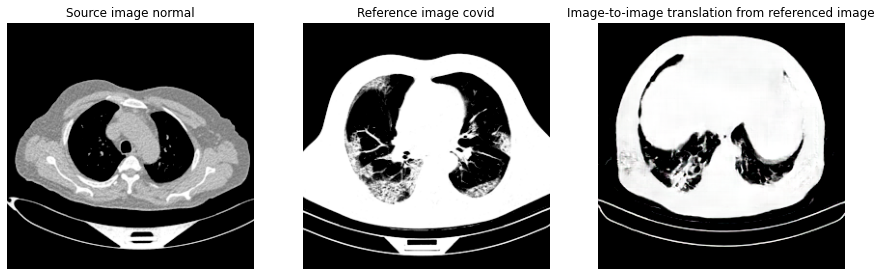

In [58]:
x, y = dataset[115]
x_ref, y_ref = dataset[60]

plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.title(f'Source image {dataset.classes[y]}')
plt.imshow(x.permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 3, 2)
plt.title(f'Reference image {dataset.classes[y_ref]}')
plt.imshow(x_ref.permute(1, 2, 0))
plt.axis(False)

x, y = x.unsqueeze(dim=0).to(DEVICE), torch.LongTensor([y])
x_ref, y_ref = x_ref.unsqueeze(dim=0).to(DEVICE), torch.LongTensor([y_ref])
with torch.inference_mode():
    encoder.eval()
    generator.eval()
    style_code = encoder(x_ref, y_ref)
    generated_image = generator(x, style_code)

plt.subplot(1, 3, 3)
plt.title('Image-to-image translation from referenced image')
plt.imshow(generated_image.cpu().squeeze(dim=0).permute(1, 2, 0))
plt.axis(False);

In [9]:
x, y = x.unsqueeze(dim=0).to(DEVICE), torch.LongTensor([y])
x_ref, y_ref = x_ref.unsqueeze(dim=0).to(DEVICE), torch.LongTensor([y_ref])

In [10]:
with torch.inference_mode():
    encoder.eval()
    generator.eval()
    style_code = encoder(x_ref, y_ref)
    generated_image = generator(x, style_code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


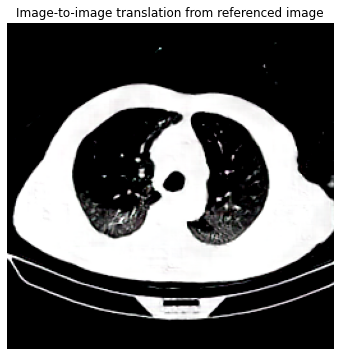

In [11]:
plt.figure(figsize=(9, 6))
plt.imshow(generated_image.cpu().squeeze(dim=0).permute(1, 2, 0))
plt.title('Image-to-image translation from referenced image')
plt.axis(False);

In [21]:
with torch.inference_mode():
    encoder.eval()
    generator.eval()
    recon_style_code = encoder(x, y)
    recon_generated_image = generator(generated_image, recon_style_code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


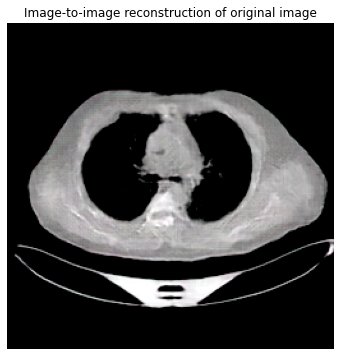

In [22]:
plt.figure(figsize=(9, 6))
plt.imshow(recon_generated_image.cpu().squeeze(dim=0).permute(1, 2, 0))
plt.title('Image-to-image reconstruction of original image')
plt.axis(False);

In [30]:
with torch.inference_mode():
    mapper.eval()
    generator.eval()
    latent_code = torch.randn(1, 16)
    latent_code = latent_code.to(DEVICE)
    mapped_style_code = mapper(latent_code, y_ref)
    generated_image = generator(x, mapped_style_code)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


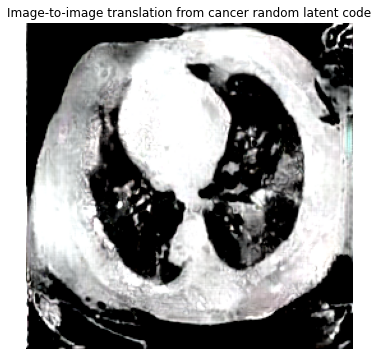

In [31]:
plt.figure(figsize=(9, 6))
plt.imshow(generated_image.cpu().squeeze(dim=0).permute(1, 2, 0))
plt.title('Image-to-image translation from cancer random latent code')
plt.axis(False);

In [1]:
!nvidia-smi

Fri Nov  4 17:53:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:8B:00.0 Off |                    0 |
| N/A   50C    P0   203W / 250W |  31695MiB / 32768MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------